In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
from astropy.time import Time
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook

import glob, os

from astropy.table import Table
plt.rcParams['font.size'] = 20

In [2]:
from scripts import *

In [3]:
targets2 = Table.read('m_dwarf_dections_27_03_20_correct_fluxes.fits')

In [4]:
targets2['common_name']

GJ 412
LP 212-62
LP 169-22
GJ 3789
GJ 1151
2MASS J09481615+5114518
2MASS J10534129+5253040
G 240-45
GJ 3729
GJ 3861
GJ 9552


In [26]:
targets = Table.read('names_best_cands_4sig_stokesv_clean_leakage_gaia_propermotion_applied stars_added_2019_10_24.fits')
names = targets['common_name']
name = 'CR Dra'
name = names[2].strip()
name = '44 Boo'
name= 'GJ 1151'
name='CR Dra'
name = 'HAT 182-00605' 
name='TIC 453430899'

stars_simultaneous = {'GJ 450':'2020-03-16T20:11:00',
         'GJ 3861':'2020-02-19T23:57:00',
         '2MASS J09481615+5114518':'2020-01-31T20:45:40',
         'LP 212-62':'2020-02-04T20:48:20'}
stars_simultaneous = {'EW Dra': '2020-04-02T22:55:34',
                      'HD 233153': '2019-12-12T19:41:00',
                      'HD 37394':'2019-12-12T19:41:00',
                      'Tau Boo': '2019-07-06T14:26:09',
                      'Wolf 1069': '2019-08-05T19:05:52',
                      'Ross 567': '2019-11-28T20:11:00',
                      'G262-15': '2019-08-17T18:06:56',
                      'UCAC4 642-113039':'2019-09-26T17:09:42',
                      'G258-33':'2019-11-10T10:48:00',
                      'G 227-22':'2019-11-10T10:48:00',
                      'IRAS21500+5903':'2019-09-18T18:11:00',
                      '54 Psc':'2019-10-19T18:11:00',
                      'HD 10780':'2019-11-03T18:31:10',
                      'UCAC4 655-108663': '2019-10-05T17:11:00',
                      'HD 223778 B': '2019-11-20T17:11:00'

}


whichstar = 1
name = list(stars_simultaneous.keys())[whichstar]
name = 'HD 223778 B'
# name = 'G 227-22'
# name = 'HD 233153'
name = 'EW Dra'
date = stars_simultaneous[name]
# name='WX Uma'
# name = 'Ross 867'
# name = 'UCAC4 444-118477'

In [27]:
list(stars_simultaneous.keys())

['EW Dra',
 'HD 233153',
 'HD 37394',
 'Tau Boo',
 'Wolf 1069',
 'Ross 567',
 'G262-15',
 'UCAC4 642-113039',
 'G258-33',
 'G 227-22',
 'IRAS21500+5903',
 '54 Psc',
 'HD 10780',
 'UCAC4 655-108663',
 'HD 223778 B']

In [30]:
search=lk.search_lightcurvefile(name,radius=60.0)

In [31]:
search

#,observation,target_name,productFilename,distance
0,TESS Sector 14,230073581,tess2019198215352-s0014-0000000230073581-0150-s_lc.fits,59.412199794505746
1,TESS Sector 15,230073581,tess2019226182529-s0015-0000000230073581-0151-s_lc.fits,59.412199794505746
2,TESS Sector 16,230073581,tess2019253231442-s0016-0000000230073581-0152-s_lc.fits,59.412199794505746
3,TESS Sector 17,230073581,tess2019279210107-s0017-0000000230073581-0161-s_lc.fits,59.412199794505746
4,TESS Sector 18,230073581,tess2019306063752-s0018-0000000230073581-0162-s_lc.fits,59.412199794505746
5,TESS Sector 19,230073581,tess2019331140908-s0019-0000000230073581-0164-s_lc.fits,59.412199794505746
6,TESS Sector 20,230073581,tess2019357164649-s0020-0000000230073581-0165-s_lc.fits,59.412199794505746
7,TESS Sector 21,230073581,tess2020020091053-s0021-0000000230073581-0167-s_lc.fits,59.412199794505746
8,TESS Sector 23,230073581,tess2020078014623-s0023-0000000230073581-0177-s_lc.fits,59.412199794505746
9,TESS Sector 24,230073581,tess2020106103520-s0024-0000000230073581-0180-s_lc.fits,59.412199794505746


In [32]:
tics, time, flux, errs, sects, data_all = load_lightcurve(name,radius=60.)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


In [33]:
period = get_rotation_period(tics,time,flux,errs)
print(period)

Finding most likely periods: 100%|██████████| 12/12 [00:01<00:00, 11.52it/s]


7.539232000663394


In [34]:
avg_preds = run_cnn(tics,time,flux,errs)

Can only use stella.ConvNN.predict().


100%|██████████| 12/12 [00:43<00:00,  3.66s/it]


In [35]:
flare_table = get_flares(tics,time,flux,avg_preds,errs)
flare_table.write('flares_%s.csv' % (name.replace(' ','_').lower()),format='ascii')

Finding & Fitting Flares: 100%|██████████| 12/12 [00:00<00:00, 62.89it/s]


In [36]:
flare_rate = get_flare_rate(time,flare_table)
print(flare_rate)

0.0 1 / d


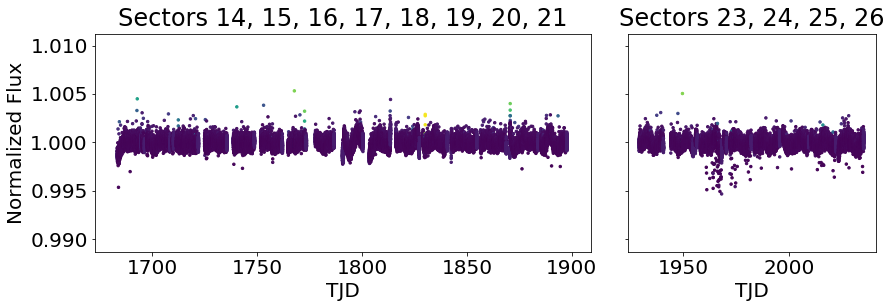

In [37]:
groups,sectors = group_sectors(data_all)
ngroups = len(groups)
width_ratios = [len(group) for group in groups] 
fig, axes = plt.subplots(ncols=ngroups, figsize=(ngroups*7,4),
                           sharey=True, gridspec_kw={'width_ratios':width_ratios})
for j, g in enumerate(groups):
    if len(groups)>1:
        ax = axes[j]
    else:
        ax = axes
    if j == 0:
        ax.set_ylabel('Normalized Flux')
    for i in g:
        ax.scatter(time[i], flux[i], c=avg_preds[i],
                    vmin=0, vmax=1, s=6)
    if len(g)==1:
        ax.set_title('Sector '+str(sectors[g[0]]),y=1.01)
    else:
        ss = [sectors[s] for s in g]
        ax.set_title('Sectors ' + ", ".join([str(s) for s in ss]),y=1.01)
    ax.set_xlabel('TJD')
yrange = np.percentile(np.hstack(flux),(2,50,98))
lims = (yrange[1]-1.0*(yrange[2]-yrange[0]), yrange[1]+1.0*(yrange[2]-yrange[0]))
# plt.ylim(*lims)
plt.subplots_adjust(wspace=0.1)
plt.savefig('results/flare_lc_%s_nozoom.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

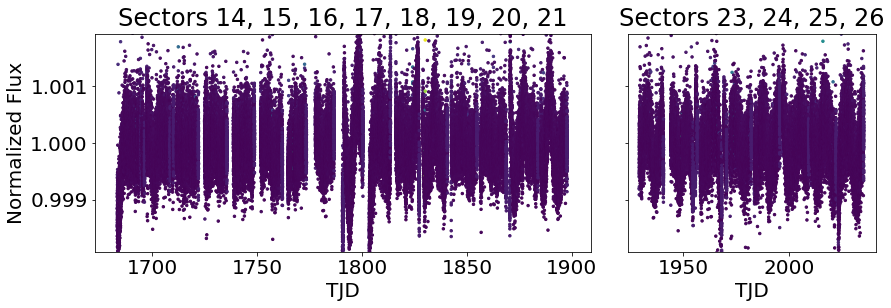

In [38]:
do_plots(tics,time,flux,avg_preds,errs,data_all)
plt.savefig('results/flare_lc_%s.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

In [39]:
dates_all = [lk.btjd_to_astropy_time(t) for t in time]
for j in range(len(dates_all)):
    print(dates_all[j].min().decimalyear,dates_all[j].max().decimalyear)

2019.5448033831847 2019.6183642719618
2019.6215453760876 2019.6881128862155
2019.6963054398138 2019.760445755243
2019.767626204158 2019.828068266596
2019.8387837988694 2019.9016424705428
2019.9084500510182 2019.9759854467127
2019.9808333210901 2020.0527939897393
2020.0571997765862 2020.1319157916816
2020.2185201893885 2020.2879109295707
2020.2904268528125 2020.362788446198
2020.366484463786 2020.4366259411909
2020.4392556699497 2020.5071962514555


In [40]:
final = data_all[-1]

In [41]:
lk.btjd_to_astropy_time(final.time).datetime64

array(['2020-06-09T18:25:18.497416377', '2020-06-09T18:27:18.495035470',
       '2020-06-09T18:29:18.492654562', ...,
       '2020-07-04T15:08:42.745625675', '2020-07-04T15:10:42.743808031',
       '2020-07-04T15:12:42.742030621'], dtype='datetime64[ns]')

In [42]:
tstart = date

t = Time(tstart, format='isot', scale='utc')

print(t.decimalyear)

2020.2539761055455


In [43]:
np.hstack(time)

array([1683.35323486, 1683.35462373, 1683.3560126 , ..., 2035.1310503 ,
       2035.13243916, 2035.13382803])

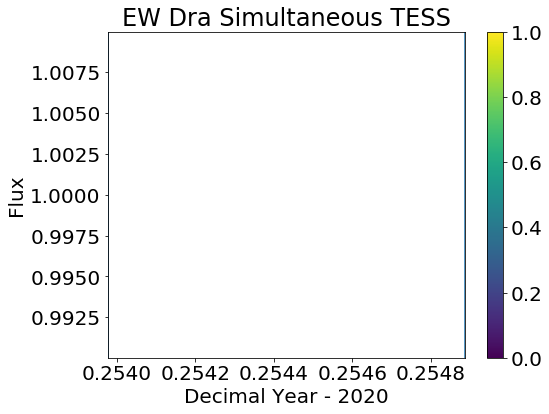

In [44]:
from astropy.time import Time, TimeDelta

dates = lk.btjd_to_astropy_time(np.hstack(time))

# tstart = '2020-05-15T20:11:00'
tstart = date
t = Time(tstart, format='isot', scale='utc')
dt = TimeDelta(3600.*8., format='sec')
tfinish = t+dt

fig = plt.figure(figsize=(8.0,6.0))
plt.scatter(dates.decimalyear-2020,np.hstack(flux),c=np.hstack(avg_preds),
                    vmin=0, vmax=1, s=6)
# plt.xlim(t.decimalyear-2020,tfinish.decimalyear-2020)
plt.axvline(t.decimalyear-2020)
plt.axvline(tfinish.decimalyear-2020)
plt.xlabel('Decimal Year - 2020')
plt.ylabel('Flux')
# plt.ylim(0.98,1.01)
plt.xlim(t.decimalyear-2020,tfinish.decimalyear-2020)
plt.colorbar()
plt.title(name+' Simultaneous TESS')
savename= (name.replace(' ','_').lower())
plt.savefig('results/%s_simultaneous.png' %  savename,bbox_inches='tight')

In [45]:
dates.shape

(192111,)

In [46]:
f = open('results/%s_output.txt' % (name.replace(' ','_').lower()),'w')
f.write('%s\n%f\n%f\n' % (name,period,flare_rate.value))
f.close()

In [47]:
savedir = 'results/'

saved_files = glob.glob(savedir+'*')


In [25]:
# saved_files